# Preprocessing Input Images of Jellyfish
This notebook summarises the steps performed to preprocess the marine plastic images.
The dataset was sourced from [Jellyfish Object Detection](https://github.com/srv/jf_object_detection).

Boundary boxes to locate objects within the figures were determined using YoloV5. The images, all containing marine plastic, can be found and corresponding boundary boxes can be found in `data_jellyfish`.

We preprocess the datasets to deal with the different figure sizes and the fact that the marine plastic and jellyfish datasets come from different sources. Firstly, a symmetric padding layer is added to make the figure sizes square. Secondly, the pixel numbers are rescaled to 100 x 100.

## Installs and imports

In [561]:
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [562]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
import os
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
from PIL import Image
from skimage.transform import resize
import random

## Reading in Data

The data are stored in `.xml` files, requiring some specific functions for reading the data



In [563]:
directory = 'jellyfish/'

#Get filenames for xml and png files, sort alphabetically
def get_filenames(target_extension, directory = directory ):
    return sorted([file for file in os.listdir(directory) if file.endswith(target_extension)])

# Read XML file (parsing)
def parse_xml(directory = directory, files_xml = files_xml, filenum = filenum):
    tree = ET.parse(directory+files_xml[filenum])
    return tree.getroot()

files_jpg = get_filenames(".jpg")
files_xml = get_filenames(".xml")


root = parse_xml()

#toy examople
filenum = 299
print(files_xml[filenum])
print(files_jpg[filenum])

pulmo12_IMG_00004.xml
pulmo12_IMG_00004.jpg


The bounding boxes are required for cropping the images to pass into the CNN

1
[[[424, 1015, 1015, 424, 424], [238, 238, 532, 532, 238]]]


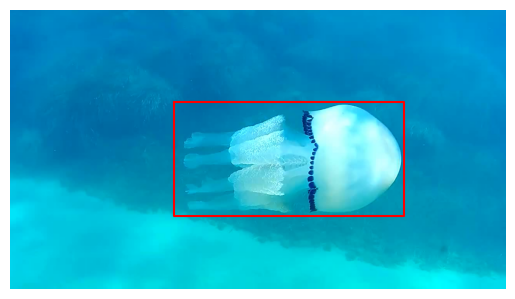

In [564]:
#get bounding box from root object
def get_bound_corners(root):
    corners = []
    for obj in root.findall('object'):     
        xmin = int(obj.find('bndbox').find('xmin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        corners.append([xmin,ymin,xmax,ymax])
    return corners

def get_bounding_boxes(root):
    coords_bb = []
    corners = get_bound_corners(root)
    print(len(corners))
    for coords in corners:    
        xmin,ymin,xmax,ymax = coords
        coords_bb.append([
                [xmin,xmax,xmax,xmin,xmin],
                [ymin,ymin,ymax,ymax,ymin]
        ])
    return coords_bb

def plot_bounding_boxes_jelly(ax, coords, **kwargs):
    print(coords)
    for coord in coords:
        x = coord[0]
        y = coord[1]
        ax.plot(x,y,**kwargs)
    


# Load the image from a file
image_path = directory+files_jpg[filenum]  # Replace with the path to your image file
img = mpimg.imread(image_path)
coords_bb = get_bounding_boxes(root)


# Display the image using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis
ax.imshow(img)
plot_bounding_boxes_jelly(ax, coords_bb, color = 'red')
plt.show()

## cropping and padding

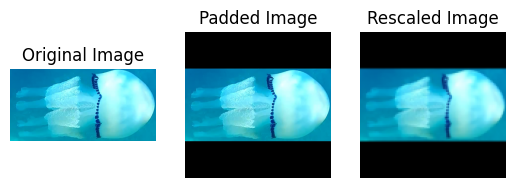

In [565]:
def rescale_image(image_array, new_shape=(100, 100)):
    # Rescale the image
    rescaled_image = resize(image_array, (new_shape[0], new_shape[1], image_array.shape[2]), anti_aliasing=True)
    
    # Convert back to uint8 type [0, 255]
    rescaled_image = (rescaled_image * 255).astype(np.uint8)
    
    return rescaled_image

def crop_pad_images(root, directory = directory, files_xml = files_jpg, filenum = filenum, plot = True):
    dir = directory+files_xml[filenum]
    img = Image.open(dir)

    bound_corners = get_bound_corners(root)    
    cropped_imgs = []
    cropped_padded_imgs = []
    cropped_padded_scaled_imgs = []
    for corners in bound_corners:
        
        # Crop the image
        cropped_img = np.array(img.crop(corners))
        height, width, channels = cropped_img.shape
        
        #sack image if too small
        if height < 50 or width < 50:
            continue
        cropped_imgs.append(cropped_img)

        #calculate padding needed to make the image square
        pad_vertical = abs(height - width) // 2
        pad_horizontal = abs(height - width) - pad_vertical
        
        #apply padding to make the image square
        if height > width:
            padded_img = np.pad(cropped_img, ((0, 0), (pad_vertical, pad_horizontal), (0, 0)), 'constant', constant_values=0)
        else:
            padded_img = np.pad(cropped_img, ((pad_vertical, pad_horizontal), (0, 0), (0, 0)), 'constant', constant_values=0)
        cropped_padded_imgs.append(padded_img)
        cropped_padded_scaled_imgs.append(rescale_image(padded_img))
        
    #plotting
    if plot == True:
        N = len(cropped_padded_imgs)
        fig, ax = plt.subplots(N, 3)
        if N == 1:
            ax[0].set(title = 'Original Image')
            ax[1].set(title = 'Padded Image')
            ax[2].set(title = 'Rescaled Image')
            ax[0].imshow(cropped_imgs[0])
            ax[0].axis('off')
            # Plot padded image
            ax[1].imshow(cropped_padded_imgs[0])
            ax[1].axis('off')
            ax[2].imshow(cropped_padded_scaled_imgs[0])
            ax[2].axis('off')
        else:
            ax[0,0].set(title = 'Original Image')
            ax[0,1].set(title = 'Padded Image')
            ax[0,2].set(title = 'Rescaled Image')
            for i in range(N):
                ax[i,0].imshow(cropped_imgs[i])
                ax[i,0].axis('off')
                # Plot padded image
                ax[i,1].imshow(cropped_padded_imgs[i])
                ax[i,1].axis('off')
                ax[i,2].imshow(cropped_padded_scaled_imgs[i])
                ax[i,2].axis('off')

    

        plt.show()
        return None
    
    return cropped_padded_scaled_imgs

crop_pad_images(root, plot = True)


## Preprocessing all data

100%|██████████| 685/685 [00:36<00:00, 18.55it/s]

number of jellyfish images: 689


(-0.5, 99.5, 99.5, -0.5)

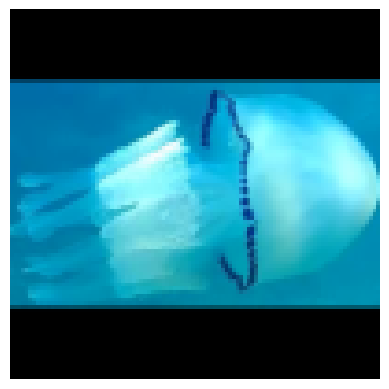

In [566]:
files_jpg = get_filenames(".jpg")
files_xml = get_filenames(".xml")
all_images = []

i = 0
for i in tqdm(range(len(files_jpg))):
    root = parse_xml(filenum = i)
    all_images+= crop_pad_images(root, filenum = i, plot = False)

print(f'number of jellyfish images: {len(all_images)}')

plt.imshow(all_images[303])
plt.axis('off')

In [567]:
#save data
all_labels = ['jellyfish']*len(all_images)
all_images = np.save('jellyfish_images.npy', np.array(all_images))
all_labels = np.save('jellyfish_labels.npy', np.array(all_labels))

[57, 93, 86, 369, 173, 685, 315]


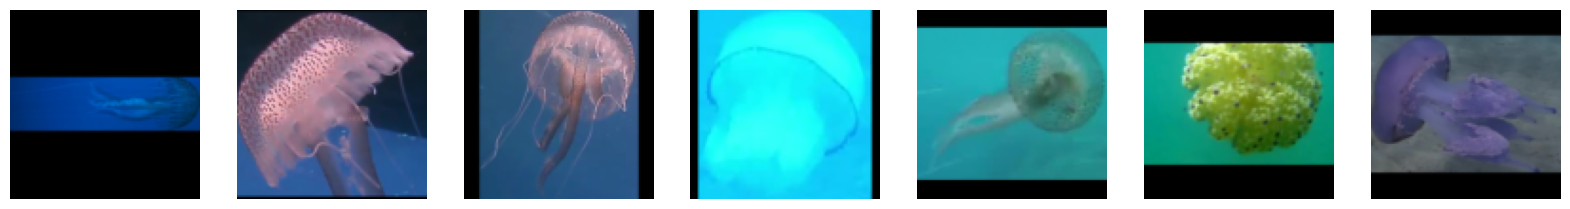

In [568]:
#check that load data works, check a few jellies at random to see that cropping, padding and scaling works
all_images_2 = np.load('jellyfish_images.npy')
random.seed(2)
Nplots = 7
indices = random.sample(range(0,int(len(all_images_2))),Nplots)
print(indices)
fig, ax = plt.subplots(1, Nplots, figsize = (20,50))

for i in range(Nplots):
    ax[i].imshow(all_images_2[indices[i]])
    ax[i].axis('off')
plt.show()
all_labels = np.load('labels.npy')
